In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate 
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals import joblib

In [2]:
# The downloaded file
data = io.loadmat('data/mnist-original.mat')

X, y = data['data'].T, data['label'].T

# Convewrt y from 2 dimension array into one dimension array
# before the split, hence, y_train, y_test will have this property as well
y = y.ravel()

# Split into to subgroups, 50% for each
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

**The size of each picture is 28X28 and they all in the data (X).**

**Reshape X_train to the dimensions of each picture 28X28 and Insert the result into a new variable named 'X_images', we will use X_train later for the model, hence, it will not be changed at this step.** 

In [3]:
X_images = X_train.reshape(35000, 28, 28)
X_images.shape

(35000, 28, 28)

In [4]:
# check how many unique classes are in y_train
np.unique(y_train) # 10 classes for ten digits

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

## Question 1

**Visualize one element from each class**

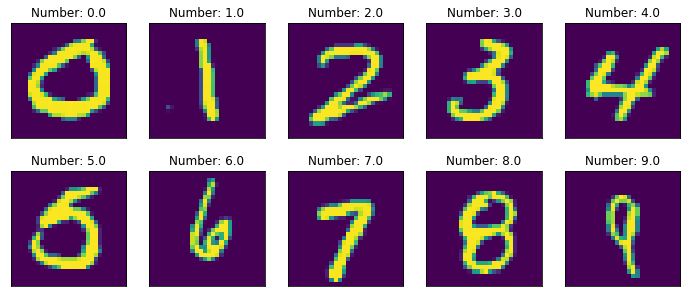

In [5]:
# Loop on X_images and y_train ten times (for each class/digit)
# Looking for the index (named 'location') in y_train
# and extract one of the proper figures from X_images

plt.figure(figsize=(12,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    location = np.where(y_train == i)[0][0] # find the first location of every class (digit)
    plt.imshow(X_images[location]) # plot a sample for each class (digit) according to the location 
    plt.title(f'Number: {y_train[location]}')
    plt.xticks([]) # Remove the x,y-axis labels (not relevant, the 28X28 size is known)
    plt.yticks([])

**Visualize the mean of each class**

In [6]:
# Combine X_image, y_train into a zipped list
# The zipped list will contain pairs of:
# one item from X_images, and one item from y_train

zipped_data = list(zip(X_images, y_train))

In [7]:
# Build a new dictionary with a loop over the zipped list
# The dictionary will be used later for the means calculations

zipped_dict = {}

for x,y2 in zipped_data:
    if y2 not in zipped_dict.keys(): # if the key is not exists, create it 
        zipped_dict[y2] = [x]
    else:
        zipped_dict[y2].append(x) # if the key exists, append it to the relevant class

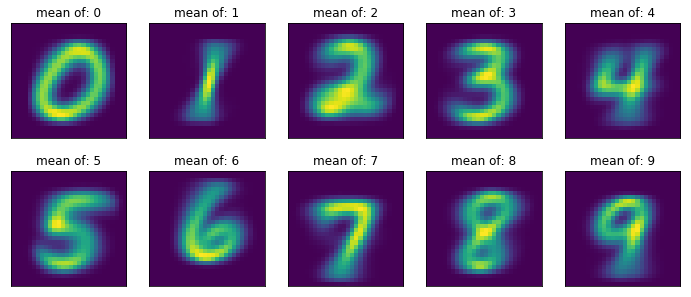

In [8]:
# Loop and plot the mean of every class (digit)

plt.figure(figsize=(12,5))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(np.mean(zipped_dict[i], axis=0)) # Plot the mean of each class (digit)
    plt.title(f'mean of: {i}')
    plt.xticks([]) # Remove the x,y-axis labels (not relevant, the 28X28 size is known)
    plt.yticks([])

## Question 2

**Fitting the initial logistic regression with its solver set to be the 'lbfgs' algorithm.**

**This is a multiple class case using a Logistic Regression model; hence, the binary model creates a separate model for each class and choose the best one for the prediction, according to probabilities. (This is the disadvantage of using Logistic Regression model on multiple classes). So, I inserted multi_class='ovr' to minimise the warnings.**

In [9]:
%%time 

# Changed to multi_class='ovr' following the warnings for multi_class

log = LogisticRegression(solver='lbfgs', multi_class='ovr')
log.fit(X_train, y_train)
print(log.score(X_test, y_test))

0.9116
CPU times: user 1min 5s, sys: 464 ms, total: 1min 6s
Wall time: 33.9 s


**Reducing the dimensionality by slicing and reducing the number of columns, the computation time is (naturally) lower since we reduced the data size. The reason is that we working now on a smaller dataset.**

In [10]:
%%time
# reducting number of columns

log = LogisticRegression(solver='lbfgs', max_iter=100, multi_class='ovr')
log.fit(X_train[:,:350], y_train)
print(log.score(X_test[:,:350], y_test))

0.7925142857142857
CPU times: user 29.1 s, sys: 171 ms, total: 29.3 s
Wall time: 14.8 s


**Reducing the number of data points reduce the computation time as well, for the same reason, the solver works on a lower number of data points. Hence, the computation time is shorter and the accuracy is lower too.**

In [11]:
%%time 
# reducing number of data points

log = LogisticRegression(solver='lbfgs', multi_class='ovr')
log.fit(X_train[:100], y_train[:100])
print(log.score(X_test[:100], y_test[:100]))

0.75
CPU times: user 322 ms, sys: 4.11 ms, total: 326 ms
Wall time: 170 ms


**one advantage for reducing dimensionality: a faster computation time.**
**one disadvantage for reducing dimensionality: we can miss some essential columns from the data resulting in a non-accurate model.**
**However, if we reduce the number dimensionality by reducing the components as an output of the PCA method, that way, we reduce the dimensionality and focus on the most critical components.** 

**one advantage of reducing the number of data points: A faster computation time.**
**one disadvantage of reducing the number of data points: if we do that without planning and thinking in advanced, we can (randomly) reject essential points from the dataset.**

## Question 3

**5-fold cross validation divides the data into five parts, train on 4 slices and test it on the last one. That will happen five times (5 combinations of the split)**

**The loop ideally runs for each value between 1~15 and plots at the end the ideal number of neighbours for the model.**

**This is not a full run since a full run takes a long run-time. (did not complete after 24 hours)**

**Hence, the choice is a randomly chosen 1000 out of the all, a portion of the dataset that runs in a reasonable run-time. the accuracy here at the pick point (around 5 neighbors) is close to 87%.**

Text(0, 0.5, 'accuracy')

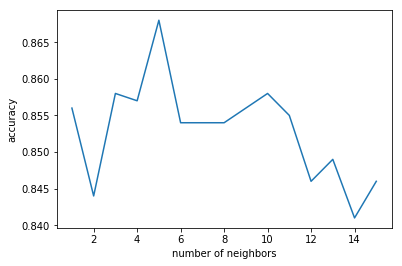

In [12]:
np.random.seed(123)

# Randomly select a subset of data
# Generating a 1000 random numbers between 0 to X.shape[0]
indx = np.random.randint(0, X.shape[0], 1000)

# 5 splits, random_state for my internal comparison
kf = KFold(n_splits=5, random_state=123)

# Array that will append the scores
scores_neighbors = []

for n in range(1,16):
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X[indx], y[indx], cv=kf)
    scores_neighbors.append(scores.mean())
plt.plot(range(1,16), scores_neighbors)
plt.xlabel('number of neighbors')
plt.ylabel('accuracy')

------------------------------------------------------------------------

**What happens to the accuracy if you set the K in KNN to 1?**

**Setting K=1 will give 100% accuracy if the model will be trained on the all dataset since we will always find one that is the closest to itself, in a case of a train set as a portion, the accuracy will not be 100% on the test set.**

------------------------------------------------------------------------

**What will happens to the accuracy if you set the k in KNN to 60000?**

**How many we have from each class? Creating a pd on y (below) reveals that there are more from class '1' compared to any other class. Hence, Setting 60000 near neighbours, the highest value is '1' so the algo will always choose '1' in this case to classify the point, the class with the highest number of images.**

In [13]:
pd.Series(y).value_counts()

1.0    7877
7.0    7293
3.0    7141
2.0    6990
9.0    6958
0.0    6903
6.0    6876
8.0    6825
4.0    6824
5.0    6313
dtype: int64

**Changing to decision trees and looping over the depth of the tree reveals a graph that shows a good result in depth 10, from 10 forwards the accuracy became slightly lower."**

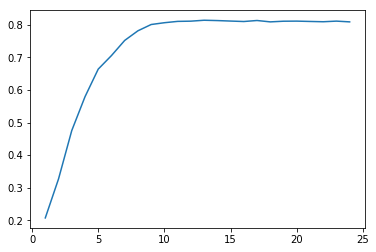

In [14]:
# randomly select a subset of data
np.random.seed(123)

# Generating 10000 random points
indx = np.random.randint(0, X.shape[0], 10000)

kf = KFold(n_splits=5, random_state=123)

scores_tree = []

for n in range(1,25):
    tree = DecisionTreeClassifier(max_depth=n)
    scores = cross_val_score(tree, X[indx], y[indx], cv=kf)
    scores_tree.append(scores.mean())
    
plt.plot(range(1,25), scores_tree)

## Question 4

In [15]:
# A Logistic Regression model
log = LogisticRegression(solver='lbfgs', multi_class='ovr')
log.fit(X_train, y_train)
print(f'The score is: {log.score(X_test, y_test)}')

The score is: 0.9116


**Creating y_predict (2) and pass it into the matrix, with the real value. (y_test)**

**The diagonal line stands out in it, the values are higher compared to the others. The higher values related to our (relatively) high score.**

**Other than the diagonal, the Inaccuracies values are relatively low, at column 8 row 2 there is an Inaccuraciy of 119 for example.**

In [17]:
y_pred2 = log.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred2), 
             columns=range(10), index=range(10))

,0,1,2,3,4,5,6,7,8,9
0,3307,0,15,9,7,14,29,5,40,4
1,0,3830,21,9,4,8,5,6,43,4
2,24,30,3081,52,40,15,34,37,119,10
3,13,8,107,3263,9,87,15,28,83,44
4,5,10,22,7,3171,6,22,17,38,136
5,41,14,25,170,41,2669,75,9,106,43
6,19,10,31,1,18,52,3240,2,27,0
7,15,14,54,19,51,10,2,3334,17,110
8,26,83,41,99,24,128,24,21,2918,58
9,20,17,16,66,93,16,2,103,40,3093


**Re-fit a linear model that can discriminate between the digit 4 and the digit 9 and visualise.**

In [18]:
# Create a variable that will contain only True and False
# for the relevant digits: 4 and 9
indx49 = np.logical_or(y_train == 4, y_train == 9)

In [19]:
log = LogisticRegression(solver='lbfgs')

# partial fit, only on the 4 and 9 digits
log.fit(X_train[indx49] , y_train[indx49])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

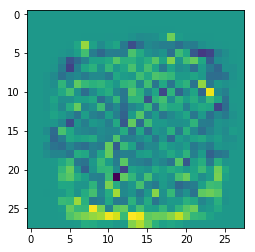

In [20]:
plt.imshow(log.coef_.reshape(28,28))

**Interpretation:**
**The yellow dots on the bottom (mainly) imply a magnitude values, these are the points that the algorithm can distinguish between the values 4 and 9.**

**There is no presentation to both digits at the bottom, where some of the yellow points located.**

## Question 5

**Starting with a Logistic Model, the hyperparameters there are the regularisation penalty values (and others), but the run time is slow, and I'm not sure that Logistic is the right fit for this model.**

**Another try made with KNN model, the run time delays the flow of the work.**

**So, the choice here was to train a decision tree, starting with the hyperparameters best values (for few selected hyperparameters), continue with splitting the train portion into a train and validate portions. In the case of a decision tree, the validation portion will help to asses the optimal Depth of the tree.**


In [22]:
# Starting again with the basic steps for practice.  
# Split into two subgroups, 50% for each
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Fit and Transform
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

**Hyperparameters Tuning for decision tree.**

**This method learned from: https://youtu.be/dA_x2xHTYQE**

In [23]:
# SOME Hyperparameters Tuning for a decision tree
# Setup the parameters and the distributions to sample, from: param_dist

param_dist = {
                "max_depth": [3, None],
                "min_samples_leaf": [2,4],
                "criterion": ["gini", "entropy"]
             }

# Instantiate a tree classifier object
tree = DecisionTreeClassifier()

# Trigger the GridSearchCV function
tree_cv = RandomizedSearchCV(tree, param_dist)

# Fit the data
tree_cv.fit(X_train, y_train)

# Print the results
print(f'The tuned decision tree parameters: {tree_cv.best_params_}')
print(f'The best score is: {tree_cv.best_score_}')

The tuned decision tree parameters: {'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
The best score is: 0.8486285714285714


**There are few hyperparameters for a decision tree, we found the best value for few of them (some combination) with an exception for the max_depth (returns 'None'), hence another check is needed.**

In [25]:
# Predict the test set results
y_pred = tree_cv.predict(X_test)

# Visualizing the results with a confusion matrix
plt.figure(figsize=(12,8))
pd.DataFrame(confusion_matrix(y_test, y_pred), 
                 columns=range(10), index=range(10))

,0,1,2,3,4,5,6,7,8,9
0,3241,7,46,33,20,48,36,9,37,19
1,2,3849,27,24,11,15,16,13,24,16
2,35,24,2931,117,50,30,67,79,92,38
3,41,39,121,3025,25,171,27,50,95,74
4,18,31,50,37,2957,18,49,41,45,172
5,46,36,55,200,51,2548,53,17,59,77
6,25,26,82,27,77,96,3012,2,43,16
7,15,38,102,59,39,20,6,3205,34,77
8,43,62,106,130,96,93,64,25,2688,106
9,21,23,45,67,170,74,19,105,68,2810


<Figure size 864x576 with 0 Axes>

**The confusion matrix values are normal for this kind of accuracy, the diagonal values are the highest, with relatively low values else that relates to model Inaccuracies.**

In [26]:
# The max_depth value output from the previous step is not satisfying,
# hence another run and plot are needed to evaluate
# the optimal value of the depth.
# Start with another split, a split of the train into: train, validate.

# Split X_train, y_train into two subgroups: train and validate, 50% each
X_train, X_validate, y_train, y_validate = \
                    train_test_split( X_train, y_train, test_size=0.5 )

scaler  = StandardScaler()

# Fit and Transform
X_train     = scaler.fit_transform(X_train)
X_validate  = scaler.transform(X_validate)


np.random.seed(123)
indx = np.random.randint(0, X.shape[0], 1000)

kf = KFold(n_splits=5, random_state=123)

# Arrays that will hold the accuracy results
acc_validate = []
acc_train    = []

# The function 'cross_validate' returns a dictionary
# my_dict will catch it
my_dict = {}

for n in range(1,20, 1):
    
    tree = DecisionTreeClassifier( max_depth=n )
    
    my_dict = cross_validate( tree, X[indx], y[indx], cv=kf ,\
                                            return_train_score=True )
        
    acc_train.append( my_dict['train_score'].mean() )
    acc_validate.append( my_dict['test_score'].mean() )

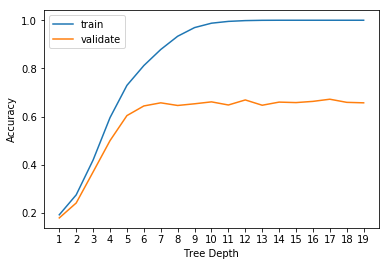

In [27]:
# Plot the accuracy scores of the train portion 
# along the validation portion scores  

plt.figure()
plt.plot(range(1,20, 1), acc_train, label='train')
plt.plot(range(1,20, 1), acc_validate, label='validate')
plt.xticks(range(1,20, 1))
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**From the plot we can see that Depth 5 Looks like an appropriate point, and higher values can lead to overfitting.**

In [43]:
# Create and save the model
DT_model = DecisionTreeClassifier( max_depth=5, \
                                   min_samples_leaf=2, \
                                   criterion='entropy' )
DT_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
joblib.dump(DT_model, 'DT_model.pkl')

['DT_model.pkl']